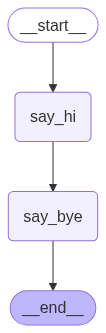

In [2]:
# framework from langchain
# Used primarily created for AI Flow



from IPython.display import Image,display
from langgraph.graph import Graph


def greet(state: str) -> str:
    name = state.get("name", "Guest")
    print(f"👋 Hello, {name}!")
    state["greeted"] = True
    return "Hello"

# Step 2: Goodbye
def goodbye(state: str) -> str:
    print("👋 Goodbye! Have a great day.")
    state["done"] = True
    return "Hello"

# Build the graph using `Graph` instead of `StateGraph`
graph = Graph()

graph.add_node(node="say_hi", action=greet)
graph.add_node(node="say_bye", action=goodbye)

# Define entry and transitions manually
graph.set_entry_point("say_hi")
graph.add_edge("say_hi", "say_bye")
graph.set_finish_point("say_bye")

# Compile and run the graph
compiledgraph = graph.compile()


display(Image(data=compiledgraph.get_graph().draw_mermaid_png()))

100%|██████████| 2/2 [00:00<00:00, 14.82it/s]


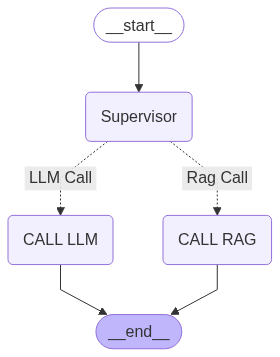

In [7]:
from langchain_openai import AzureOpenAIEmbeddings,AzureChatOpenAI
from azure.identity import DefaultAzureCredential,get_bearer_token_provider
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_chroma import Chroma 
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pydantic import BaseModel,Field
from typing import TypedDict,Annotated,Sequence,Literal
from langchain_core.messages import BaseMessage
import operator
from langgraph.graph import StateGraph,END
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate



token_provider= get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")


embeddingmodel= AzureOpenAIEmbeddings(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    azure_deployment= "text-embedding-ada-002",
    model= "text-embedding-ada-002"
)
embeddings_date=embeddingmodel.embed_query("hello")
#print(len(embeddings_date))


model= AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    azure_deployment= "gpt-4o-mini",
    model= "gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)


###  Data into Vector DB
#Loader
loader = DirectoryLoader("../data", glob="**/*.txt", show_progress=True)
docs = loader.load()
#print(docs[0].page_content)

#Textsplitting
text_splitter=RecursiveCharacterTextSplitter(chunk_size=200,chunk_overlap=10)
chunks=text_splitter.split_documents(docs)
#print(chunks)

#Store in Chroma
vector_store =Chroma("ChinaData",embedding_function=embeddingmodel)
vector_store .add_documents(chunks)
results = vector_store.similarity_search(
    "For how many years will the recruited experts serve in the think tank?",
    k=2
)
#print(results)




#Creating Pydantic Classes
class RoutingDecisionWithReason(BaseModel):
    route: Literal["LLM Call", "Rag Call"] = Field(description="Routing decision")
    reasoning: str = Field(description="Reasoning behind the routing decision")

# Parser
parser = PydanticOutputParser(pydantic_object=RoutingDecisionWithReason)

# Prompt template with partial_variables for parser instructions
supervisorprompt = PromptTemplate(
    template=(
        "Given the user input below, decide the appropriate routing for processing. If the quetion is based on Focus then go for RAG call\n"
        "Respond in JSON format matching the schema.\n\n"
        "{format_instructions}\n\n"
        "User input: {user_input}"
    ),
    input_variables=["user_input"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

#State management class
class AgentState(TypedDict):
    mesages:Annotated[Sequence[BaseMessage],operator.add]

# Adding Functions for LangGraph
def Supervisor(state: AgentState):
    input=state["mesages"][-1]
    print("Input",input)
    return "Hello"


def ragcall(state: AgentState):
    return "Hello"

def llmcall(state: AgentState):
    return "Hello"

def router(state: AgentState):
    pass


workflow=StateGraph(AgentState)

workflow.add_node("Supervisor",Supervisor)
workflow.add_node("CALL RAG",ragcall)
workflow.add_node("CALL LLM",llmcall)

workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges(
        "Supervisor",
         router,
         {
             "Rag Call" : "CALL RAG",
             "LLM Call" : "CALL LLM"

         }
)

workflow.add_edge("CALL RAG",END)
workflow.add_edge("CALL LLM",END)


compiledworkflow = workflow.compile()


display(Image(data=compiledworkflow.get_graph().draw_mermaid_png()))




In [45]:
print(supervisorprompt)

input_variables=['user_input'] input_types={} partial_variables={'format_instructions': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"route": {"description": "Routing decision", "enum": ["LLM Call", "Rag Call"], "title": "Route", "type": "string"}, "reasoning": {"description": "Reasoning behind the routing decision", "title": "Reasoning", "type": "string"}}, "required": ["route", "reasoning"]}\n```'} template='Given the user input below, decide the appropriate routing for processing. If the quetion is based on Focus then go for RAG call\nRespond in JSON format mat

In [ ]:
# Adding Fnctions for LangGraph
def Supervisor(state: AgentState):
    question = state["messages"][-1]
    chain = supervisorprompt | model | parser
    response = chain.invoke({"user_input":question})
    print(response.route)

In [48]:
state = {"messages" :["Why do we need Focus"]}
Supervisor(state)

route='Rag Call' reasoning='The question is based on Focus, which requires a RAG call for processing.'
